In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])
%matplotlib inline

## Load results

In [21]:
all_out = glob("out/**/*.pkl")

In [22]:
all_out = [load_pickle(p) for p in all_out]

In [23]:
all_out

[{'tabpfn_metrics': {'accuracy': 0.6687116564417178,
   'acc_macro': 0.6687116564417178,
   'racc': 0.6687116564417178,
   'kappa': 0.0,
   'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]),
   'f1_macro': 0.4007352941176471,
   'f1_micro': 0.6687116564417178,
   'frac_valid': 1.0,
   'all_y_true': (#326) [1,1,1,1,1,0,0,0,0,0...],
   'all_y_pred': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [24]:
extracted_res = []
xgboost_results = []
tabpfn_results = []
dummy_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgb_metrics"]["accuracy"],
        "f1_macro": out["xgb_metrics"]["f1_macro"],
        "f1_micro": out["xgb_metrics"]["f1_micro"],
        "kappa": out["xgb_metrics"]["kappa"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_metrics"]["accuracy"],
        "f1_macro": out["tabpfn_metrics"]["f1_macro"],
        "f1_micro": out["tabpfn_metrics"]["f1_micro"],
        "kappa": out["tabpfn_metrics"]["kappa"],
    }

    dummy_res = {
        "train_size": out["train_size"],
        "accuracy": out["dummy_metrics"]["accuracy"],
        "f1_macro": out["dummy_metrics"]["f1_macro"],
        "f1_micro": out["dummy_metrics"]["f1_micro"],
        "kappa": out["dummy_metrics"]["kappa"],
    }

    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)
    dummy_results.append(dummy_res)

In [25]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)
dummy_res = pd.DataFrame(dummy_results)

In [26]:
grouped_res = res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [27]:
grouped_xgboost_res = xgboost_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [28]:
grouped_dummy_res = dummy_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [29]:
grouped_tabpfn_res = tabpfn_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [30]:
grouped_res.loc[:]

frac_valid                  accuracy                            \
                 mean  std count  sem      mean       std count       sem   
train_size                                                                  
10                1.0  0.0     7  0.0  0.695042  0.021250     7  0.008032   
20                1.0  0.0     6  0.0  0.661439  0.064784     6  0.026448   
50                1.0  0.0     7  0.0  0.751833  0.094236     7  0.035618   

            f1_macro                            f1_micro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.463671  0.066787     7  0.025243  0.695042  0.021250     7   
20          0.440609  0.041232     6  0.016833  0.661439  0.064784     6   
50          0.496054  0.065670     7  0.024821  0.751833  0.094236     7   

                         kappa                            
                 sem      mean       std count       sem  
train_size                                                
10          0.008032  0.023450  0.071350     7  0.026968  
20          0.026448 -0.006779  0.055130     6  0.022507  
50          0.035618  0.058570  0.089338     7  0.033766

In [31]:
grouped_tabpfn_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.656893  0.033110     7  0.012514  0.426957  0.092317     7   
20          0.614233  0.086151     6  0.035171  0.405953  0.025528     6   
50          0.739496  0.103272     7  0.039033  0.452007  0.077154     7   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.034893  0.656893  0.033110     7  0.012514  0.044148  0.116804   
20          0.010422  0.614233  0.086151     6  0.035171 -0.021965  0.062392   
50          0.029161  0.739496  0.103272     7  0.039033  0.021110  0.106668   

                            
           count       sem  
train_size                  
10             7  0.044148  
20             6  0.025472  
50             7  0.040317

In [32]:
grouped_xgboost_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.643587  0.064985     7  0.024562  0.494930  0.126601     7   
20          0.627978  0.069232     6  0.028264  0.446654  0.081037     6   
50          0.728261  0.099291     7  0.037529  0.458145  0.071482     7   

                      f1_micro                               kappa            \
                 sem      mean       std count       sem      mean       std   
train_size                                                                     
10          0.047851  0.643587  0.064985     7  0.024562  0.085428  0.192818   
20          0.033083  0.627978  0.069232     6  0.028264  0.016692  0.127687   
50          0.027018  0.728261  0.099291     7  0.037529  0.013623  0.095635   

                            
           count       sem  
train_size                  
10             7  0.072878  
20             6  0.052128  
50             7  0.036146

In [33]:
grouped_dummy_res

accuracy                            f1_macro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.645948  0.011109     7  0.004199  0.392424  0.004095     7   
20          0.584036  0.168356     6  0.068731  0.361455  0.081838     6   
50          0.750029  0.116098     7  0.043881  0.426453  0.037476     7   

                      f1_micro                           kappa                  
                 sem      mean       std count       sem  mean  std count  sem  
train_size                                                                      
10          0.001548  0.645948  0.011109     7  0.004199   0.0  0.0     7  0.0  
20          0.033410  0.584036  0.168356     6  0.068731   0.0  0.0     6  0.0  
50          0.014164  0.750029  0.116098     7  0.043881   0.0  0.0     7  0.0

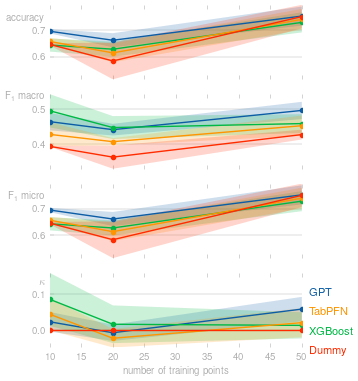

In [34]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
    )

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[ :].index,
            grouped_res.loc[:][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[ :].index,
            grouped_res.loc[:][metric]["mean"] - grouped_res.loc[ :][metric]["sem"],
            grouped_res.loc[ :][metric]["mean"] + grouped_res.loc[ :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[ :].index,
            grouped_xgboost_res.loc[ :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[ :].index,
            grouped_xgboost_res.loc[:][metric]["mean"]
            - grouped_xgboost_res.loc[ :][metric]["sem"],
            grouped_xgboost_res.loc[:][metric]["mean"]
            + grouped_xgboost_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[ :].index,
            grouped_tabpfn_res.loc[ :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[ :].index,
            grouped_tabpfn_res.loc[:][metric]["mean"]
            - grouped_tabpfn_res.loc[ :][metric]["sem"],
            grouped_tabpfn_res.loc[ :][metric]["mean"]
            + grouped_tabpfn_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_dummy_res.loc[ :].index,
            grouped_dummy_res.loc[ :][metric]["mean"],
            marker="o",
            label="Dummy",
        )
        ax[i].fill_between(
            grouped_dummy_res.loc[ :].index,
            grouped_dummy_res.loc[:][metric]["mean"]
            - grouped_dummy_res.loc[ :][metric]["sem"],
            grouped_dummy_res.loc[ :][metric]["mean"]
            + grouped_dummy_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

    matplotx.line_labels(ax[-1], fontsize=8)
    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)

    fig.savefig("mof_synthesizability-classification_results_2.pdf", bbox_inches="tight")

In [35]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2

In [ ]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2